### 냉각기가 센서의 온도에 영향을 얼마나 미치는지 보는 것이 목적이므로
- 냉각기의 가동 시작 시간을 기준으로 key 값 설정

### Import & Data load

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from tqdm import tqdm
import os

_dir = '_19'
_file_ls = os.listdir(_dir)
_file_ls

freez1 = pd.read_csv(os.path.join(_dir, _file_ls[0]))
suth1 = pd.read_csv(os.path.join(_dir, _file_ls[2]))

freez1.columns
freez1.columns = ['freezer_id', 'gw_time', 'status', 'fan_run', 'fan_trip',
       'freez_run', 'freez_trip', 'defrost', 'ctrl_mode', 'ctrl_operation',
       'operation', 'run_time', 'insert_dt']

suth1.columns
suth1.columns = ['sensor_id', 'gw_time', 'status', 'color_list', 'avg_temperature',
       'avg_humidity', 'temperature', 'humidity', 'battery', 'available',
       'insert_dt']


In [3]:
freez1

,freezer_id,gw_time,status,fan_run,fan_trip,freez_run,freez_trip,defrost,ctrl_mode,ctrl_operation,operation,run_time,insert_dt
0,61,2019-01-01 00:00:39,1,1.0,0.0,1.0,0.0,0.0,1,1,1,0,2019-01-01 00:00:40
1,61,2019-01-01 00:01:10,1,1.0,0.0,1.0,0.0,0.0,1,1,1,1,2019-01-01 00:01:10
2,61,2019-01-01 00:01:40,1,1.0,0.0,1.0,0.0,0.0,1,1,1,1,2019-01-01 00:01:40
3,61,2019-01-01 00:02:10,1,1.0,0.0,1.0,0.0,0.0,1,1,1,2,2019-01-01 00:02:11
4,61,2019-01-01 00:02:40,1,1.0,0.0,1.0,0.0,0.0,1,1,1,2,2019-01-01 00:02:41
...,...,...,...,...,...,...,...,...,...,...,...,...,...
613337,491,2019-01-31 23:57:50,1,0.0,0.0,0.0,0.0,1.0,0,1,1,1437,2019-01-31 23:57:50
613338,491,2019-01-31 23:58:21,1,0.0,0.0,0.0,0.0,1.0,0,1,1,1438,2019-01-31 23:58:21
613339,491,2019-01-31 23:58:51,1,0.0,0.0,0.0,0.0,1.0,0,1,1,1438,2019-01-31 23:58:51
613340,491,2019-01-31 23:59:21,1,0.0,0.0,0.0,0.0,1.0,0,1,1,1439,2019-01-31 23:59:21


In [42]:
# No. 16
sensor_id = [290, 293, 296, 299]
freezer_id = [308,314,320,326]

df_sensor = pd.DataFrame()
df_freezer = pd.DataFrame()

for elem in sensor_id:
    df_sensor = pd.concat([df_sensor, suth1[suth1['sensor_id'] == elem]])
    print("sensor id {}의 데이터 개수: {}".format(elem, len(suth1[suth1['sensor_id'] == elem])))
for elem in freezer_id:
    df_freezer = pd.concat([df_freezer, freez1[freez1['freezer_id'] == elem]])
    print("freezer id {}의 데이터 개수: {}".format(elem, len(df_freezer[df_freezer['freezer_id'] == elem])))


print(df_sensor['sensor_id'].unique())
print(df_freezer['freezer_id'].unique())

sensor id 290의 데이터 개수: 4067
sensor id 293의 데이터 개수: 4067
sensor id 296의 데이터 개수: 4061
sensor id 299의 데이터 개수: 4061
freezer id 308의 데이터 개수: 7023
freezer id 314의 데이터 개수: 7023
freezer id 320의 데이터 개수: 7023
freezer id 326의 데이터 개수: 7023
[290 293 296 299]
[308 314 320 326]


### type 변환 및 sorting

In [43]:
df_freezer = df_freezer.sort_values(by = 'gw_time', ascending= True).reset_index(drop = True)
df_sensor = df_sensor.sort_values(by = 'gw_time', ascending= True).reset_index(drop = True)

df_freezer['gw_time'] = pd.to_datetime(df_freezer['gw_time'])
df_sensor['gw_time'] = pd.to_datetime(df_sensor['gw_time'])


### key 생성

In [44]:
df_freezer['key'] = [x for x in range(len(df_freezer))]
df_sensor['key'] = [None]*len(df_sensor)

### Mapping

In [45]:
from tqdm import tqdm
for i in tqdm(range(len(df_freezer))):
    df_sensor.loc[(df_sensor['gw_time'] - df_freezer.loc[i,'gw_time'] <= dt.timedelta(seconds = 30))&(df_sensor['gw_time'] - df_freezer.loc[i,'gw_time'] > dt.timedelta(seconds = 0)), 'key'] = df_freezer.loc[i,'key']

100%|██████████| 28092/28092 [00:36<00:00, 765.30it/s]


In [68]:
df = pd.merge(df_freezer, df_sensor, how = 'outer', on = 'key').sort_values(by = 'key')
key = df['key']
gw_time_x = df['gw_time_x']
gw_time_y = df['gw_time_y']
df = df.drop(columns= ['key','gw_time_x','gw_time_y'])
df.insert(0,'key',key)
df.insert(1,'gw_time_x',gw_time_x)
df.insert(2,'gw_time_y',gw_time_y)
df.sort_values(by = 'key')

C:\Users\Intellicode\AppData\Local\Temp\ipykernel_1132\2415347013.py:1: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  df = pd.merge(df_freezer, df_sensor, how = 'outer', on = 'key').sort_values(by = 'key')


,key,gw_time_x,gw_time_y,freezer_id,status_x,fan_run,fan_trip,freez_run,freez_trip,defrost,...,sensor_id,status_y,color_list,avg_temperature,avg_humidity,temperature,humidity,battery,available,insert_dt_y
0,0.0,2019-01-29 13:56:14,NaT,308.0,1.0,0.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2019-01-29 13:56:14,NaT,320.0,1.0,1.0,0.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,2019-01-29 13:56:14,NaT,326.0,1.0,1.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.0,2019-01-29 13:56:14,NaT,314.0,1.0,1.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,2019-01-29 13:56:15,NaT,308.0,1.0,0.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40322,None,NaT,2019-01-31 23:26:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,293.0,0.0,"{""humidity"": ""yellow"", ""temperature"": ""red"", ""...",0.00,19.61,-0.68,19.92,100.0,1.0,2019-01-31 23:26:06
40323,None,NaT,2019-01-31 23:29:07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,299.0,3.0,"{""total_status"": ""grey""}",-0.03,19.88,-99999.00,-99999.00,-99999.0,0.0,2019-01-31 23:29:08
40324,None,NaT,2019-01-31 23:29:07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,290.0,0.0,"{""humidity"": ""green"", ""temperature"": ""red"", ""t...",-0.03,19.88,-2.33,22.54,100.0,1.0,2019-01-31 23:29:08
40325,None,NaT,2019-01-31 23:29:07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,296.0,0.0,"{""humidity"": ""yellow"", ""temperature"": ""red"", ""...",-0.03,19.88,2.95,17.04,100.0,1.0,2019-01-31 23:29:08


In [69]:
# mapping 안된 데이터 개수
df_sensor['key'].isnull().sum()

168

In [70]:
df0 = df.copy()

In [71]:
df0.columns

Index(['key', 'gw_time_x', 'gw_time_y', 'freezer_id', 'status_x', 'fan_run',
       'fan_trip', 'freez_run', 'freez_trip', 'defrost', 'ctrl_mode',
       'ctrl_operation', 'operation', 'run_time', 'insert_dt_x', 'sensor_id',
       'status_y', 'color_list', 'avg_temperature', 'avg_humidity',
       'temperature', 'humidity', 'battery', 'available', 'insert_dt_y'],
      dtype='object')

In [72]:
df0['sensor_id'].unique()

array([ nan, 290., 296., 299., 293.])

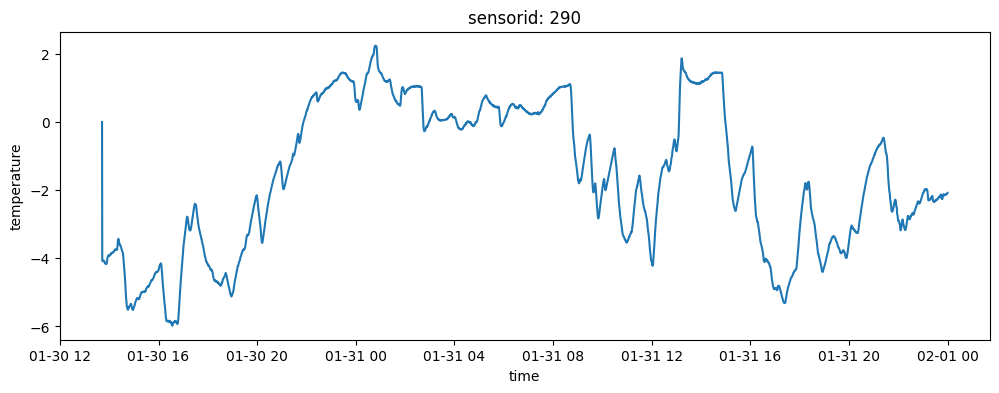

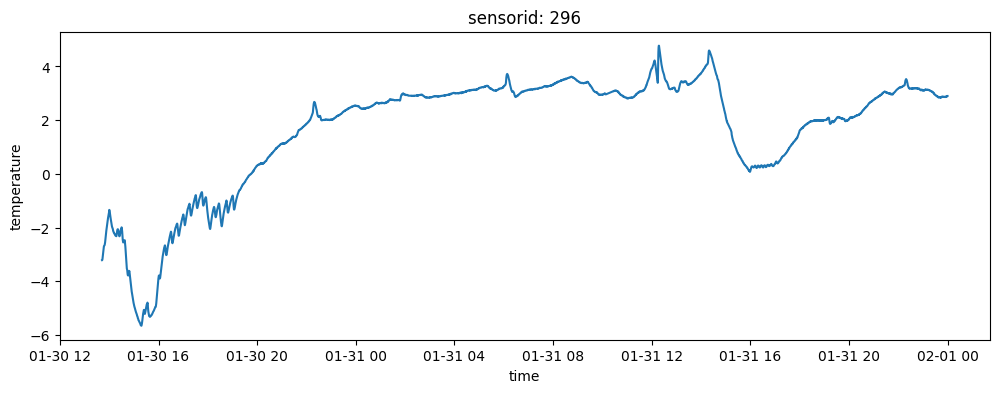

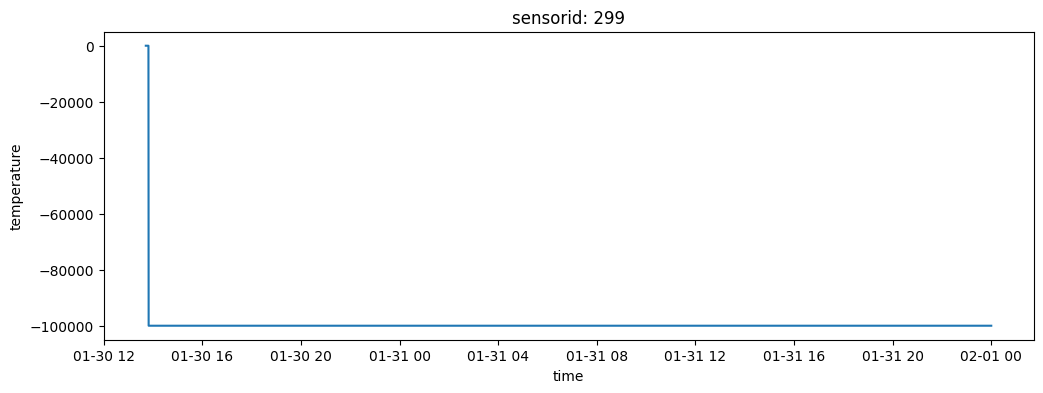

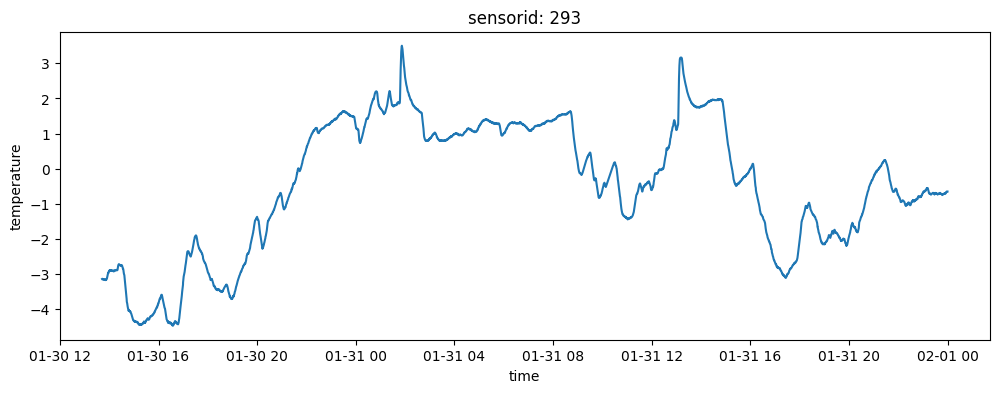

In [79]:
import seaborn as sns
for elem in [290, 296, 299, 293]:
    plt.figure(figsize=(12, 4))
    plt.title(f"sensorid: {elem}")
    sns.lineplot(x = 'gw_time_x', y = 'temperature', data = df0[df0['sensor_id'] == elem])
    sns.lineplot(x = 'gw_time_x', y = )
    plt.xlabel('time')
    plt.ylabel('temperature')
    plt.show()